In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import transformers

In [82]:
df = pd.read_csv('dataset.csv')

In [83]:
df.head()

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [85]:
df.isnull().sum()

text     0
humor    0
dtype: int64

In [86]:
#BALANCED DATASET (No need for oversampling or changing weights)

In [87]:
df['humor'].value_counts()

False    100000
True     100000
Name: humor, dtype: int64

<AxesSubplot:>

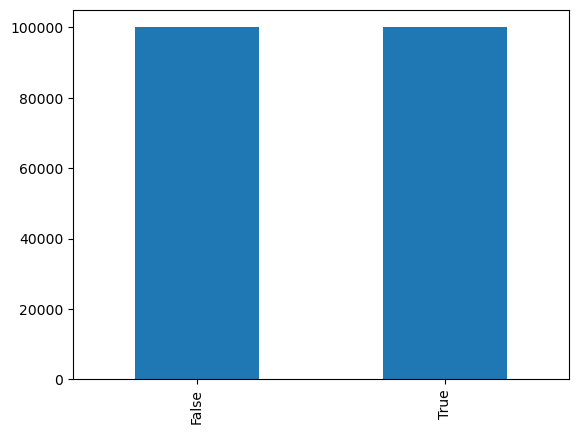

In [88]:
df['humor'].value_counts().plot(kind='bar')

In [89]:
df['funny'] = pd.get_dummies(df['humor'], drop_first=True)

In [90]:
df.head()

,text,humor,funny
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,0
1,Watch: darvish gave hitter whiplash with slow ...,False,0
2,What do you call a turtle without its shell? d...,True,1
3,5 reasons the 2016 election feels so personal,False,0
4,"Pasco police shot mexican migrant from behind,...",False,0


In [91]:
df = df.drop('humor', axis=1)

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   funny   200000 non-null  uint8 
dtypes: object(1), uint8(1)
memory usage: 1.7+ MB


In [93]:
X=df['text']
y=df['funny']

In [94]:
X = list(X)
y = list(y)

In [95]:
from sklearn.model_selection import train_test_split


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [97]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

In [98]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenized_train_data = tokenizer(X_train, return_tensors="np", padding=True) 
tokenized_test_data = tokenizer(X_test, return_tensors="np", padding=True)
labels = np.array(y_train) 

In [99]:
model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_layer_norm', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_79', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [100]:
model.compile(optimizer=Adam(3e-5))

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [101]:
model.fit(dict(tokenized_train_data), labels)

5000/5000 [==============================] - 19443s 4s/step - loss: 0.0601


In [102]:
dict(tokenized_train_data)

{'input_ids': array([[ 101, 3422, 2023, ...,    0,    0,    0],
        [ 101, 2027, 4191, ...,    0,    0,    0],
        [ 101, 4931, 1010, ...,    0,    0,    0],
        ...,
        [ 101, 2139, 7716, ...,    0,    0,    0],
        [ 101, 5765, 2375, ...,    0,    0,    0],
        [ 101, 2339, 2079, ...,    0,    0,    0]]),
 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])}

In [103]:
y_pred = model.predict(dict(tokenized_test_data))

1250/1250 [==============================] - 756s 604ms/step


In [104]:
y_pred

TFSequenceClassifierOutput(loss=None, logits=array([[-4.8236003,  4.5994425],
       [-4.8147063,  4.565136 ],
       [ 0.9987289, -0.9423677],
       ...,
       [-4.827612 ,  4.5101776],
       [ 3.550344 , -3.536122 ],
       [ 3.6313987, -3.5309737]], dtype=float32), hidden_states=None, attentions=None)

In [105]:
logits = y_pred.logits
softmax = tf.nn.softmax(logits)
predictions = np.argmax(softmax.numpy(), axis=1)

In [106]:
y_test = np.array(y_test)

In [107]:
predictions

array([1, 1, 0, ..., 1, 0, 0])

In [108]:
y_test

array([1, 1, 0, ..., 1, 0, 0])

In [109]:
from sklearn.metrics import confusion_matrix, classification_report

In [110]:
cm = confusion_matrix(y_test, predictions)

In [111]:
cr = classification_report(y_test, predictions)

In [112]:
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", cr)

Confusion Matrix:
 [[19709   291]
 [  229 19771]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     20000
           1       0.99      0.99      0.99     20000

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

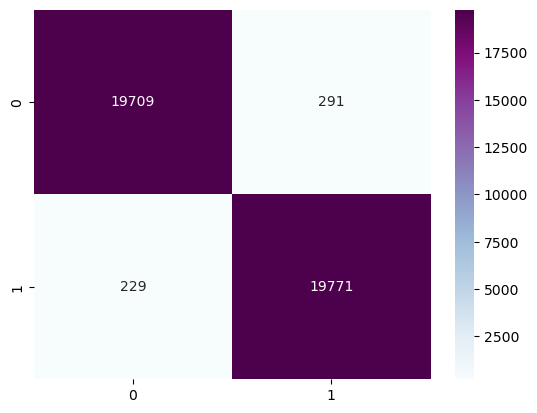

In [114]:
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='g')